<a href="https://colab.research.google.com/github/angelrodriguez0617/CS-4710-Machine-Learning-II/blob/main/A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Neural style transfer

### The content loss

### The style loss

### Neural style transfer in Keras

**Getting the style and content images**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


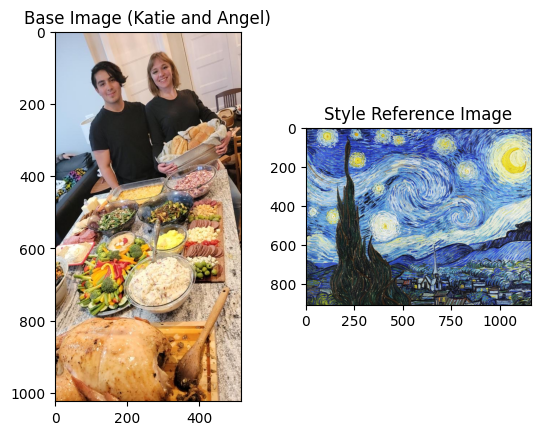

In [15]:
from tensorflow import keras
from google.colab import drive
from IPython.display import Image
import matplotlib.pyplot as plt


drive.mount('/content/drive')

# Specify the path to the selfie image
file_path = '/content/drive/MyDrive/Thanksgiving.jpg'

# base_image_path = keras.utils.get_file(
#     "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
base_image_path = file_path
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

# Create a figure and subplots.
fig, axs = plt.subplots(1, 2)
# Display the base image in the first subplot.
axs[0].imshow(plt.imread(base_image_path))
axs[0].set_title('Base Image (Katie and Angel)')
# Display the style reference image in the second subplot.
axs[1].imshow(plt.imread(style_reference_image_path))
axs[1].set_title('Style Reference Image')
# Show the plot.
plt.show()

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

**Auxiliary functions**

In [2]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**Using a pretrained VGG19 model to create a feature extractor**

In [3]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 3s 0us/step


**Content loss**

In [4]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

**Style loss**

In [5]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

**Total variation loss**

In [6]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

**Defining the final loss that you'll minimize**

In [7]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

**Setting up the gradient-descent process**

In [8]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

Iteration 100: loss=10188.34
Iteration 200: loss=5770.28
Iteration 300: loss=4672.72
Iteration 400: loss=4784.88
Iteration 500: loss=4080.90
Iteration 600: loss=4157.73
Iteration 700: loss=3670.43
Iteration 800: loss=3652.79
Iteration 900: loss=3485.91
Iteration 1000: loss=3416.03
Iteration 1100: loss=3384.05
Iteration 1200: loss=3451.97
Iteration 1300: loss=3211.50
Iteration 1400: loss=3173.80
Iteration 1500: loss=3149.63
Iteration 1600: loss=3152.80
Iteration 1700: loss=3076.00
Iteration 1800: loss=3057.34
Iteration 1900: loss=3027.44
Iteration 2000: loss=3009.19
Iteration 2100: loss=2991.25
Iteration 2200: loss=2975.49
Iteration 2300: loss=2961.37
Iteration 2400: loss=2948.72
Iteration 2500: loss=2937.33
Iteration 2600: loss=2927.00
Iteration 2700: loss=2917.54
Iteration 2800: loss=2908.92
Iteration 2900: loss=2900.97
Iteration 3000: loss=2893.60
Iteration 3100: loss=2886.77
Iteration 3200: loss=2880.47
Iteration 3300: loss=2874.63
Iteration 3400: loss=2869.17
Iteration 3500: loss=2

### Wrapping up

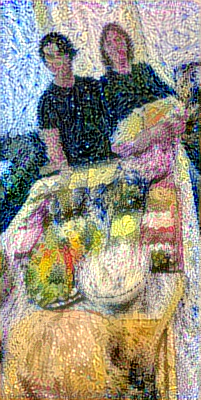

In [9]:
Image(filename='combination_image_at_iteration_100.png')

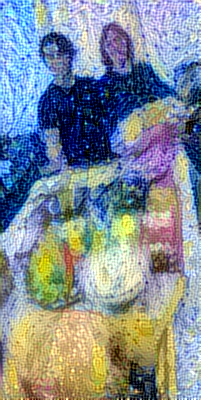

In [10]:
Image(filename='combination_image_at_iteration_4000.png')